<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/3%EC%A3%BC%EC%B0%A8/Naver_Shopping_Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **네이버 쇼핑 리뷰 감성 분류하기**

# **1. Colab에 Mecab 설치**
 형태소 분석기 Mecab을 사용합니다.

 참고로 Colab에서 실습하는 경우가 아니라면 아래의 방법으로 Mecab이 설치되지 않습니다.

In [41]:
# Colab에 Mecab 설치/ 형태소 분석기 Mecab을 사용
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


# **2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리**

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **1) 데이터 로드하기**

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7950ceb127d0>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


# **2) 훈련 데이터와 테스트 데이터 분리하기**

현재 갖고 있는 데이터는 레이블을 별도로 갖고있지 않습니다. 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여합니다. 부여된 레이블은 새로 생성한 label이라는 열에 저장합니다.

In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
#각 열에 대해서 중복을 제외한 샘플의 수를 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [9]:
#NULL 값 유무를 확인
print(total_data.isnull().values.any())

False


In [10]:
#훈련 데이터와 테스트 데이터를 3:1 비율로 분리합니다.
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


# **3) 레이블의 분포 확인**

<Axes: >

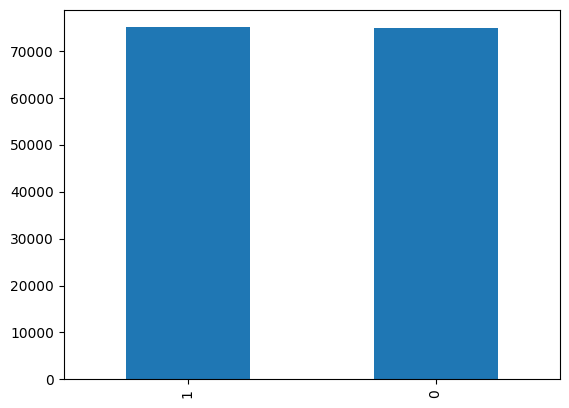

In [11]:
#훈련 데이터의 레이블의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


# **4) 데이터 정제하기**

In [13]:
#정규 표현식을 사용하여 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-13-7fd6903b4870>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


In [14]:
#테스트 데이터에 대해서도 같은 과정을 거칩니다.
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-14-2e4409826f1a>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


# **5) 토큰화**

In [15]:
# 임의의 문장에 대해서 테스트한 토큰화 결과
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [16]:
#불용어를 지정하여 필요없는 토큰들은 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)#훈련 데이터에 형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])#훈련 데이터에 불용어를 지정하여 필요없는 토큰들은 제거
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)#테스트 데이터에 형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])#테스트 데이터에 불용어를 지정하여 필요없는 토큰들은 제거

# **6) 단어와 길이 분포 확인하기**

In [18]:
#부정/긍정에서 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [19]:
#부정 단어 빈도수 카운트
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31802), ('는데', 20197), ('안', 19719), ('어요', 14838), ('있', 13200), ('너무', 13057), ('했', 11766), ('좋', 9803), ('배송', 9677), ('같', 8997), ('어', 8929), ('구매', 8869), ('거', 8861), ('없', 8672), ('아요', 8640), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7985)]


In [20]:
#부정 단어 빈도수 카운트
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39422), ('아요', 21186), ('네요', 19894), ('어요', 18673), ('잘', 18603), ('구매', 16165), ('습니다', 13320), ('있', 12391), ('배송', 12274), ('는데', 11635), ('합니다', 9801), ('했', 9783), ('먹', 9640), ('재', 9274), ('너무', 8398), ('같', 7867), ('만족', 7259), ('거', 6484), ('어', 6330), ('쓰', 6291)]


긍정 리뷰의 평균 길이 : 13.579646194659592
부정 리뷰의 평균 길이 : 17.03148775995088


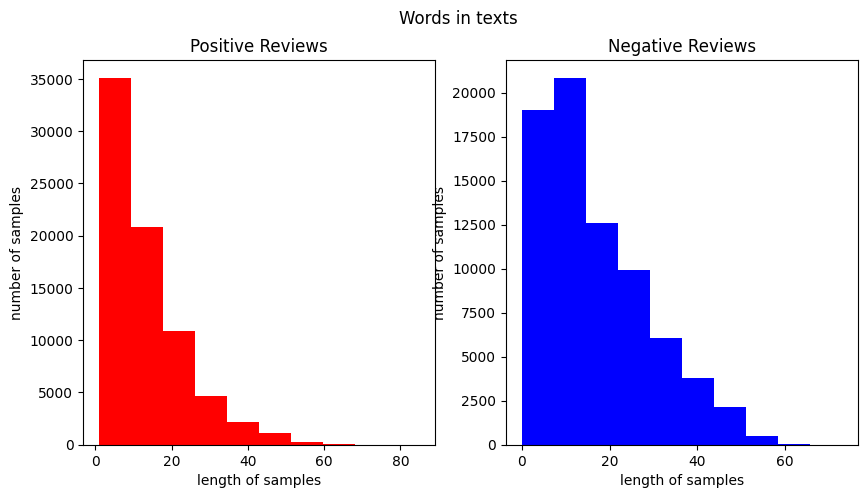

In [21]:
#두 가지 경우에 대해서 각각 길이 분포를 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [22]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

# **7) 정수 인코딩**
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [23]:
#정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [24]:
#등장 횟수가 1회인 단어들은 자연어 처리에서 배제. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40127
등장 빈도가 1번 이하인 희귀 단어의 수: 18275
단어 집합에서 희귀 단어의 비율: 45.5429012884093
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7964299021840265


단어가 약 40,000개가 존재합니다. 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 45%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%밖에 되지 않습니다. 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 중요하지 않을 것으로 저자는 판단했습니다. 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다. 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한합니다.

In [25]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21854


In [26]:
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
print(X_train[:3])

[[67, 2060, 300, 14294, 263, 73, 6, 237, 168, 136, 801, 2940, 626, 2, 76, 62, 207, 40, 1344, 155, 3, 6], [482, 400, 52, 8525, 2592, 2450, 338, 2941, 251, 2351, 39, 473, 2], [45, 24, 832, 104, 35, 2366, 160, 7, 10, 8058, 4, 1319, 30, 138, 323, 44, 59, 160, 138, 7, 1916, 2, 113, 163, 1385, 307, 119, 135]]


# **8) 패딩**
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

In [28]:
print(X_test[:3])

[[14, 704, 767, 115, 186, 252, 12], [338, 3907, 62, 3819, 1624], [11, 69, 2, 49, 164, 3, 27, 15, 6, 514, 289, 17, 92, 110, 584, 59, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.304473391093236


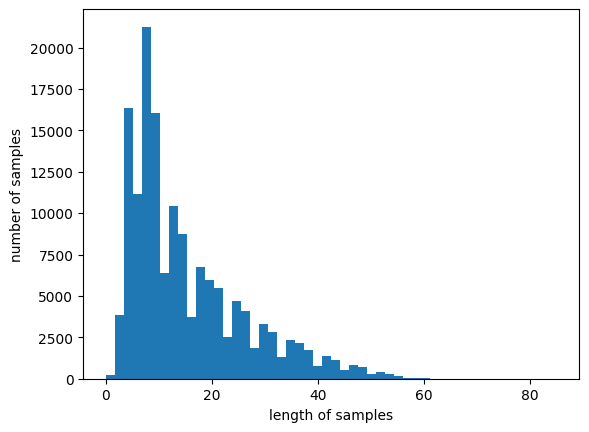

In [29]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [31]:
#최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [32]:
#훈련용 리뷰의 99.99%가 80이하 이므로 훈련용 리뷰를 길이 80으로 패딩하겠습니다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# **3. GRU로 네이버 쇼핑 리뷰 감성 분류하기**
**EarlyStopping**(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다. validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [33]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2951 - acc: 0.8853
Epoch 1: val_acc improved from -inf to 0.91153, saving model to best_model.h5
1875/1875 [==============================] - 50s 23ms/step - loss: 0.2951 - acc: 0.8853 - val_loss: 0.2410 - val_acc: 0.9115
Epoch 2/15
   1/1875 [..............................] - ETA: 14s - loss: 0.2464 - acc: 0.8906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - ETA: 0s - loss: 0.2290 - acc: 0.9174
Epoch 2: val_acc improved from 0.91153 to 0.91886, saving model to best_model.h5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2290 - acc: 0.9174 - val_loss: 0.2253 - val_acc: 0.9189
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2073 - acc: 0.9263
Epoch 3: val_acc did not improve from 0.91886
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2073 - acc: 0.9263 - val_loss: 0.2310 - val_acc: 0.9126
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1937 - acc: 0.9322
Epoch 4: val_acc improved from 0.91886 to 0.92360, saving model to best_model.h5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1937 - acc: 0.9322 - val_loss: 0.2140 - val_acc: 0.9236
Epoch 5/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1816 - acc: 0.9369
Epoch 5: val_acc did not improve from 0.92360
1875/1875 [==

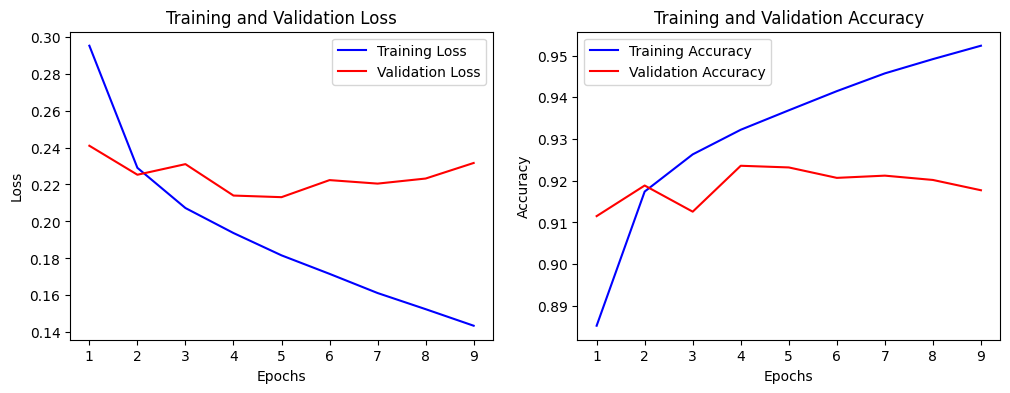

In [34]:
import matplotlib.pyplot as plt

# 훈련 손실 및 정확도
train_loss = history.history['loss']
train_acc = history.history['acc']

# 검증 손실 및 정확도
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# 에포크 수
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 5s 3ms/step - loss: 0.2186 - acc: 0.9221

 테스트 정확도: 0.9221


# **EarlyStopping** 안할경우

Epoch 1/15
1875/1875 [==============================] - 36s 18ms/step - loss: 0.2954 - acc: 0.8864 - val_loss: 0.2581 - val_acc: 0.9051
Epoch 2/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2292 - acc: 0.9172 - val_loss: 0.2414 - val_acc: 0.9119
Epoch 3/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2075 - acc: 0.9270 - val_loss: 0.2229 - val_acc: 0.9210
Epoch 4/15
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1935 - acc: 0.9324 - val_loss: 0.2155 - val_acc: 0.9217
Epoch 5/15
1875/1875 [==============================] - 12s 7ms/step - loss: 0.1816 - acc: 0.9375 - val_loss: 0.2148 - val_acc: 0.9239
Epoch 6/15
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1713 - acc: 0.9414 - val_loss: 0.2141 - val_acc: 0.9236
Epoch 7/15
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1608 - acc: 0.9460 - val_loss: 0.2204 - val_acc: 0.9201
Epoch 8/15
1875/1875 [==============================] 

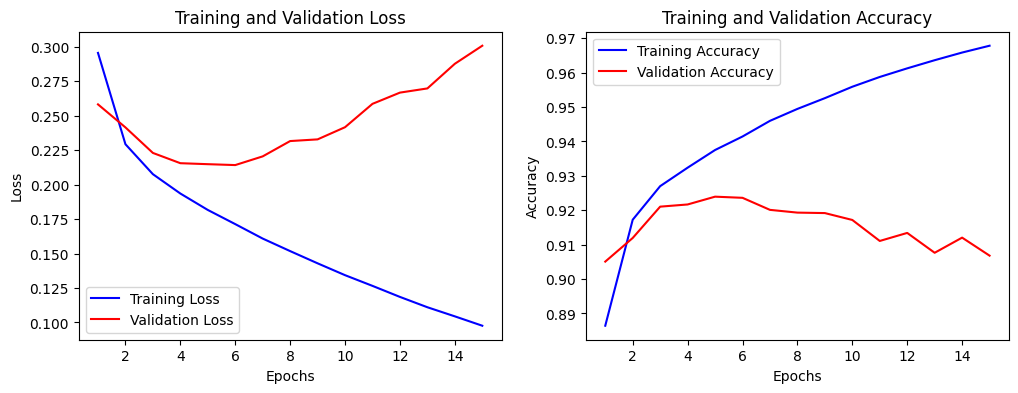

In [36]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)

import matplotlib.pyplot as plt

# 훈련 손실 및 정확도
train_loss = model.history.history['loss']
train_acc = model.history.history['acc']

# 검증 손실 및 정확도
val_loss = model.history.history['val_loss']
val_acc = model.history.history['val_acc']

# 에포크 수
epochs = range(1, len(train_loss) + 1)

# 손실 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [37]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 5s 3ms/step - loss: 0.2186 - acc: 0.9221

 테스트 정확도: 0.9221


## **4. 리뷰 예측해보기**
임의의 문장에 대한 예측을 위해서는 학습하기 전 전처리를 동일하게 적용해줍니다.

전처리의 순서: 정규 표현식을 통한 한국어 외 문자 제거 -> 토큰화, 불용어 제거 ->정수 인코딩 -> 패딩

In [38]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [39]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

1/1 [==============================] - 0s 323ms/step
96.68% 확률로 긍정 리뷰입니다.


In [40]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

1/1 [==============================] - 0s 21ms/step
99.65% 확률로 부정 리뷰입니다.
